# Theoratical Aspects

- Previously we just had dense layers in 2D now we have 3D inputs
- We can have Convolution Layers, Max Pooling Layers aswell in the CNN
- Filters determine the patterns the CNN can compute
- Stride determines how quickly the filter is moving across the inputs
- Padding deals with edges, append zeros to these edges



- Max pooling layers are fow downsampling, take something at a higher resolution and take it down to a lower resolution, shrinks the amount of data the NN has to look at as it flows through the layers
- Convnetjs is a handy website that allows us to create a CNN
- Softmax classifier at the end with 10 classes, the class with the brightest color is the target class.

- Flatten is used to flatten the layers so that we can go back to adding back the dense and fully connected layers after the conv and max pooling layers have been added.

- GPU has a limited amount of memory so it will give exhaustion error so it is better to perform such operations in batches that require more memory

- The weights of imagenet dataset can be utilized for own use



# Helper Methods

In [7]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Experimenting with MNIST Dataset

In [26]:
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print "%s images in the training dataset, each image of dimensions %s x %s" % (x_train.shape[0], x_train.shape[1], x_train.shape[2])
print "%s images in the training dataset, each image of dimensions %s x %s" % (x_test.shape[0], x_test.shape[1], x_test.shape[2])

print "Data is grayscale"

60000 images in the training dataset, each image of dimensions 28 x 28
10000 images in the training dataset, each image of dimensions 28 x 28
Data is grayscale


# Displaying data as matrix

In [27]:
from IPython.display import display
import pandas as pd

print("Shape for dataset: {}".format(x_train.shape))
print("Labels: {}".format(y_train))

# Single MNIST digit
single = x_train[0]
print("Shape for single: {}".format(single.shape))

display(pd.DataFrame(single.reshape(28,28)))

Shape for dataset: (60000, 28, 28)
Labels: [5 0 4 ... 5 6 8]
Shape for single: (28, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,...,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,...,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,...,0,0,0,0,0,0,0,0,0,0


Image (#105): Which is digit '1'


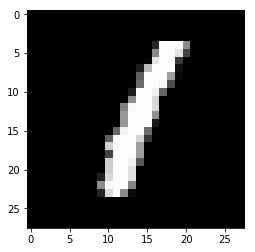

In [28]:

# Display as image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
digit = 105 # Change to choose new digit
a = x_train[digit]
plt.imshow(a, cmap='gray', interpolation='nearest')
print("Image (#{}): Which is digit '{}'".format(digit,y_train[digit]))

In [29]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
batch_size = 128
num_classes = 10
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

('x_train shape:', (60000, 28, 28, 1))
Training samples: 60000
Test samples: 10000


# Training/Fitting

In [31]:
import tensorflow as tf
import time

start_time = time.time()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
 - 95s - loss: 0.2643 - acc: 0.9181 - val_loss: 0.0546 - val_acc: 0.9819
Epoch 2/12
 - 89s - loss: 0.0889 - acc: 0.9736 - val_loss: 0.0410 - val_acc: 0.9857
Epoch 3/12
 - 90s - loss: 0.0676 - acc: 0.9800 - val_loss: 0.0359 - val_acc: 0.9878
Epoch 4/12
 - 87s - loss: 0.0554 - acc: 0.9832 - val_loss: 0.0303 - val_acc: 0.9897
Epoch 5/12
 - 95s - loss: 0.0477 - acc: 0.9856 - val_loss: 0.0321 - val_acc: 0.9894
Epoch 6/12
 - 93s - loss: 0.0432 - acc: 0.9866 - val_loss: 0.0300 - val_acc: 0.9895
Epoch 7/12
 - 97s - loss: 0.0382 - acc: 0.9889 - val_loss: 0.0271 - val_acc: 0.9905
Epoch 8/12
 - 96s - loss: 0.0336 - acc: 0.9902 - val_loss: 0.0284 - val_acc: 0.9913
Epoch 9/12
 - 97s - loss: 0.0326 - acc: 0.9899 - val_loss: 0.0277 - val_acc: 0.9919
Epoch 10/12
 - 98s - loss: 0.0316 - acc: 0.9902 - val_loss: 0.0264 - val_acc: 0.9914
Epoch 11/12
 - 96s - loss: 0.0291 - acc: 0.9907 - val_loss: 0.0276 - val_acc: 0.9904
Epoch 12/12
 - 89s - los

In [32]:
from sklearn import metrics

# For GPU just grab the first 100 images
small_x = x_test[1:100]
small_y = y_test[1:100]
small_y2 = np.argmax(small_y,axis=1)
pred = model.predict(small_x)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(small_y2, pred)
print('Accuracy: {}'.format(score))

Accuracy: 1.0
